- Inputs
    - PSPS Report Processing, Duration of events
        - 2 months of data
        - 3 events
    - CIMIS Weather Station Data
        - 200 Weather Stations
        - 13 readings from the weather station:  wind, humidity, temp, etc.
        - Total records:  230k, 1 hour each
        -~Cross-check events and weather stations~ 
            - Obtained list of 9 impacted counties from 2021 de-energizations
            - Filtered list of 102 weather stations by these counties
- Outputs
    - Trained model for predicting risk
    -* How can it be used?
        - Ex. Next 5 days, low fire risk at weather stations x,y,z with prob %
- Methods
    - Document reading/table extraction for PSPS data
    - Access CIMIS API
    - Join/match data sources based on time
    - During PSPS event, extreme wind/humidity values were observed
        - ~Pull 2020 and 2019 data for Dec/Jan~
            - Were there any high threshold events with no PSPS?  False Negatives?
                - No PSPS events for Dec 2018/19 - Jan 2019/20, but multiple humidity/wind crossings
            - And False Positives?  A PSPS event with no high values?
            -* Investigate correlation of Wind with Humidity
            -* Compute statistics for positives/negatives
    - Built a prediction model to anticipate extreme wind/humidity
        -* Produce a statistic:  Prob of high wind in next x days
        -* Train model for next 2,3,7 days?
        -* Train with Wind, Humidity only
- Challenges/Insights
    - Data feed morning/evening.  How to handle new data?
    - Input from metereology to improve/tune models
    - Relationship between wind/humidity, wind brings humidity down, increasing fire risk
    - GluonTS quantifies risk
    
   
- ~RNN with more layers!~ 20 Layers!
- ~Are the actual values within the 99th percentile?~ Metrics computed based on this criteria
- Baseline of False positives and negatives

Further Investigation
- Lottery Ticket Hypothesis, Network pruning, adjust weights based on new data, knowledge distillation
- Rather than predicting magntiude, predicting derivatives may be easier
- Oct/Nov Data

For Rafee
- What is reuseable?
- Slides are a must.
- Write 2-3 lines for presentation

CLEAN UP
- Standardize training data
- Standardize test data
- Standardize metric computations/comparisons

In [432]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
from collections import defaultdict, Counter
from itertools import chain, starmap

In [2]:
source = pd.read_csv("../data/source.csv", parse_dates=["start", "end"])

In [346]:
wr = pd.read_csv("../data/weather/weather_report_DecJan.csv", parse_dates=["Date"])
wr = wr[~wr.duplicated()]

In [347]:
wr["Hour"] = pd.Timedelta('1h') * wr["Hour"]/100

In [348]:
wr["Time"] = wr["Date"] + wr["Hour"]

<AxesSubplot:>

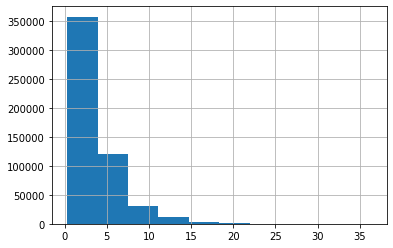

In [349]:
wind_speed = wr["HlyWindSpd (MPH)"]
wind_speed[wind_speed < 100].hist()

In [350]:
# wr.columns = wr.columns.str.lower()
# wr.columns = wr.columns.str.replace("%", "perc")
# wr.columns = wr.columns.str.replace("°", "degrees")
# wr.columns = wr.columns.str.replace(" ", "")
# wr.columns

#wr.columns[wr.columns.str.contains("Hly")].str.replace("Hly", "")

### Start/End Dates for Dec-Jan PSPS Events

In [351]:
se_dates = source[["start", "end"]]
se_dates = se_dates[~se_dates.duplicated()].sort_values(by="start").reset_index(drop=True)
se_dates.iloc[6:]

,start,end
6,2020-12-04,2020-12-14
7,2020-12-16,2020-12-24
8,2021-01-12,2021-01-21


### Matching Notifications of PSPS Event by County against CIMIS Data

In [352]:
notifications = pd.read_csv("../data/2021/deenergization_2021.csv", parse_dates=True)
ws = pd.read_csv("../data/weather/weather_stations.csv", parse_dates=True)

notif_by_county = notifications.County.value_counts().sort_values()
notif_by_county = notif_by_county

counties = []
for county in notif_by_county.index:
     for c in county.split(";"):
            counties.append(c.title())

psps_county_stations = ws[ws.County.isin(counties)].StationNbr

len(set(counties)), len(psps_county_stations.values)

(9, 102)

In [353]:
wind_max = wr[wr.Station.isin(psps_county_stations.values)][["Station", "HlyWindSpd (MPH)"]].groupby("Station").max()
wind_max = wind_max[(wind_max > 25) & (wind_max < 60)].dropna()
wind_max

,HlyWindSpd (MPH)
Station,
125,30.6
197,29.5
204,28.0
234,26.1


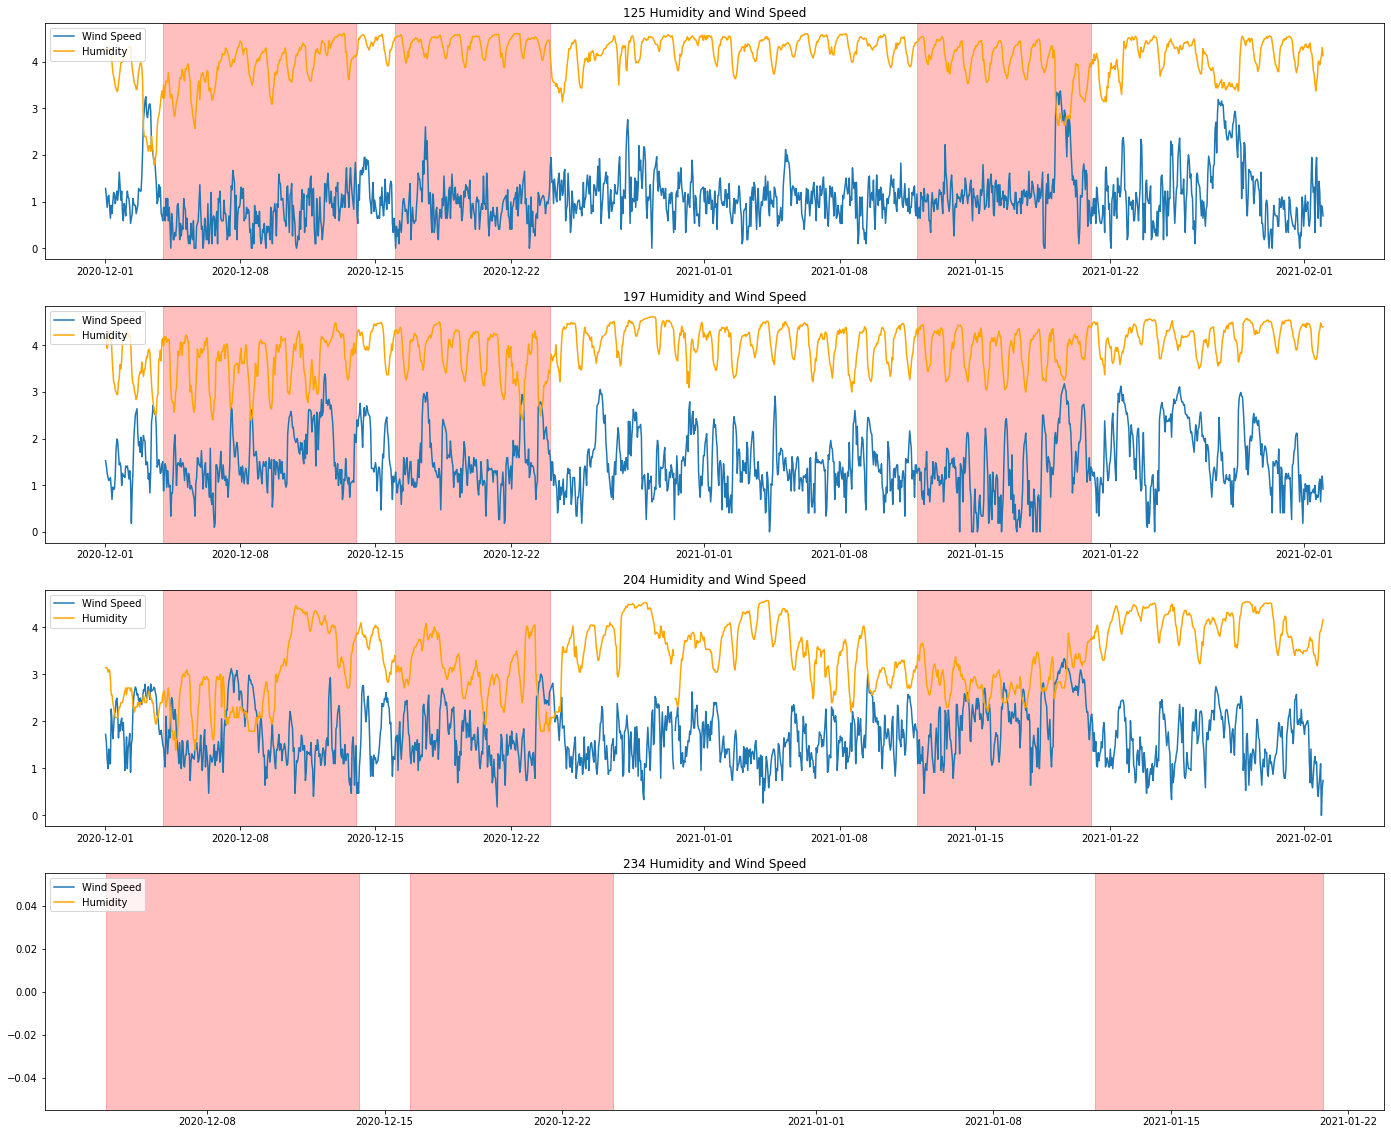

In [13]:
stations = wind_max.index
dates = se_dates.iloc[6:]
fig, ax = plt.subplots(len(stations), 1,figsize=(24,20))
for (s, v_ax) in zip(stations, ax):
        wrs = wr[(wr.Station==s) & (wr.Date >= "2020-12-01")]
        wrs.set_index("Time", inplace=True)
        
        # For a single date range, narrow plot to that range
        if len(dates.index) == 2:
            wrs = wrs.loc[dates.start:dates.end]
            
        v_ax.plot(np.log(wrs["HlyWindSpd (MPH)"]), label="Wind Speed")
        
        v_ax.plot(np.log(wrs["HlyRelHum (%)"]), color="orange", label="Humidity")
        v_ax.set_title("{} Humidity and Wind Speed".format(s))
        
        # For multiple date ranges, highlight relevant time
        if len(dates.index) > 2:
            for (start, end) in dates.values:
                v_ax.axvspan(start, end, color='red', alpha=0.25)

        v_ax.legend(loc="upper left")
#         v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#         v_ax[1].set_title("{} Wind Speed Increments".format(s))
            
#         v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#         v_ax[3].set_title("{} Humidity".format(s))


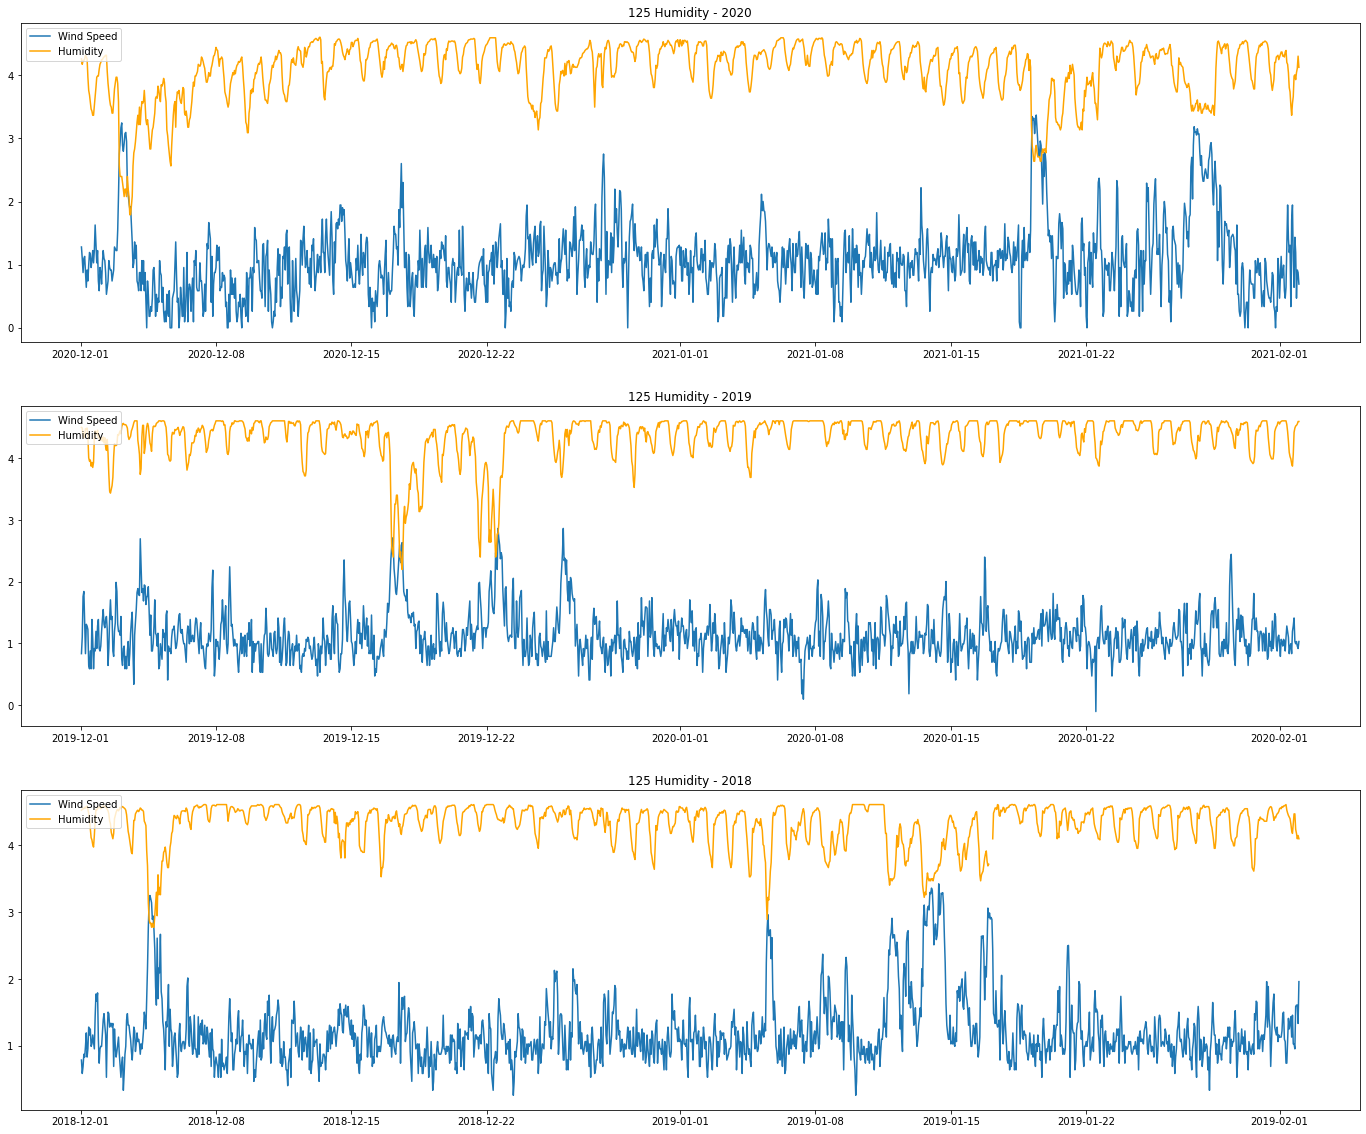

In [14]:
s = 125
wrs = wr[(wr.Station==s)].set_index("Time")

two_months = pd.Timedelta("62d")

fig, ax = plt.subplots(3, 1,figsize=(24,20))
for (year, v_ax) in zip(["2020", "2019", "2018"], ax): 
        start = pd.Timestamp("{}-12-01".format(year))
        end = start + two_months
    
        v_ax.plot(np.log(wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyWindSpd (MPH)"]), label="Wind Speed")
        
        v_ax.plot(np.log(wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyRelHum (%)"]), color="orange", label="Humidity")
        v_ax.set_title("{} Humidity - {}".format(s, year))
        
        # For multiple date ranges, highlight relevant time
#         v_ax.axvspan("{}-12-01".format(year), "2021-01-21", color='red', alpha=0.25)

        v_ax.legend(loc="upper left")
#         v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#         v_ax[1].set_title("{} Wind Speed Increments".format(s))
            
#         v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#         v_ax[3].set_title("{} Humidity".format(s))


## GlutonTS

In [266]:
from gluonts.model.predictor import Predictor
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator

In [65]:
from gluonts.mx.distribution.gamma import GammaOutput
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.canonical import CanonicalRNNEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator # Not working?  NaN loss in most epochs
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.mx.trainer import Trainer

In [354]:
#(wr.Date.dt.year >= 2020) & (wr.Date.dt.month >= 12) & (wr.Station.isin(psps_county_stations.values))
wr_gts = wr.copy()
wr_gts.set_index("Time", inplace=True)
# wr_gts = wr_gts[wr_gts.columns[(wr_gts.columns.str.contains("Hly")) | (wr_gts.columns.str.contains("Station"))]]

In [355]:
target_columns = wr_gts.columns[wr_gts.columns.str.contains("Hly")]

keys = []
targets = []
for (key, df) in wr_gts.groupby(["Station", pd.Grouper(freq='1AS-DEC')]):
        tss = df[target_columns].transpose().iterrows()
        for (c, ts) in tss:
            targets.append(ts)
            keys.append((*key, c))

In [364]:
target_dict = {key:target for (key, target) in zip(keys, targets)}

# By default, take up to 
training_data = ListDataset(
    [{"start": df.index[0], "target": df.loc[:"2021-01-17 00:00:00"]} for df in targets],
    freq = "60min"
)

training_data_year = ListDataset(
    [{"start": df.index[0], "target": df.loc[:"2020-02-01 00:00:00"]} for (key, df) in zip(keys, targets) if key[1].year < 2020],
    freq = "60min"
)

training_data_ws = ListDataset(
    [{"start": df.index[0], "target": df} for (key, df) in zip(keys, targets) if key[0] not in [125, 197, 204, 234]],
    freq = "60min"
)

### Model Parameters
- model = Deep AR Estimator
- all   = 2018-2021 Dec-Jan Data
- e     = epochs
- L     = Layers
- CL    = Context Length (default = prediction_length)

### Models
- model-initial:  2021 data only
- model-all-e100-2L
- model-all-e100-4L
- model-all-e20-4L-30CL:  Worst performance.  Assumed due to long context length
- model-all-e20-4L-7CL:  Better compared to 30CL, but still bad.  
- model-all-e100-20L: Trained on all data
- model-2021-e100-20L:  Trained on 2019/20 and 2020/21 Dec-Jan data, best performance yet in most cases?
- model-year-e100-20L:  Trained on 2018 - Feb 2020 data only

In [358]:
estimator = DeepAREstimator(freq="60min", prediction_length=24*3, trainer=Trainer(epochs=100, batch_size=32), num_layers=20)
# estimator = DeepFactorEstimator(freq="60min", prediction_length=24*3, trainer=Trainer(epochs=100, learning_rate=.00001))

### Train a new model...

In [365]:
predictor = estimator.train(training_data=training_data_year)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [01:04<00:00,  1.28s/it, epoch=100/100, avg_epoch_loss=0.403] 


In [467]:
predictor.serialize(Path("../models/model-ws-e100-20L"))

### ...or load an existing one!

In [476]:
predictor = Predictor.deserialize(Path("../models/model-all-e100-20L"))

### Visualize Predictions

In [395]:
wr_test = wr_gts[(wr_gts.Station==88) & (wr_gts.Date.dt.year==2021)]
# wr_test.set_index("Time", inplace=True)
wr_test = wr_test[target_columns]

test_data = ListDataset(
    [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-01-20 00:00:00", c]} for c in target_columns],
    freq = "60min"
)

In [396]:
sforecast_it, sts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=1000,  # number of sample paths we want for evaluation
)

In [399]:
sforecasts = list(sforecast_it)
stss = list(sts_it)

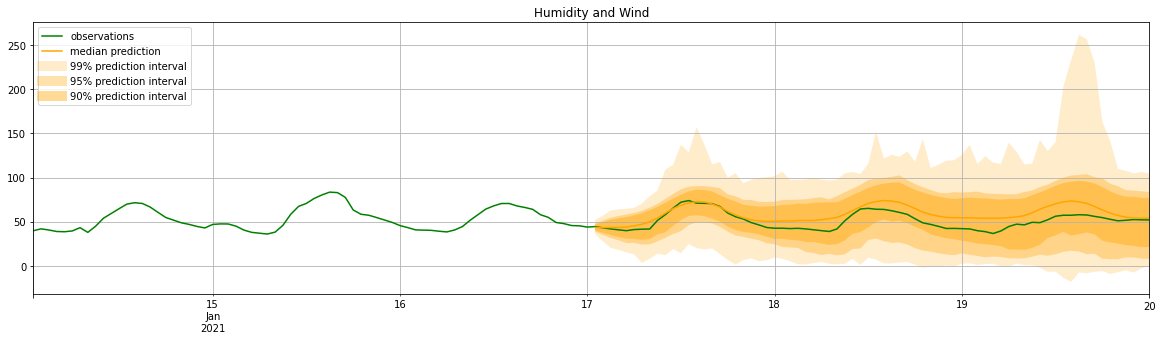

In [402]:
plot_length = 2*3*24
prediction_intervals = [90,95,99]
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(20, 5))

# Humidity
# i = 7
# tss[i][-plot_length:].plot(ax=ax, color="red")  # plot the time series
# forecasts[i].plot(prediction_intervals=prediction_intervals, color='orange')

# Wind
i = 0
stss[i][-plot_length:].plot(ax=ax, color="green")  # plot the time series
sforecasts[i].plot(prediction_intervals=prediction_intervals, color='orange')

#ax.set_xbound("2021-01-17", "2021-01-19")
# ax.set_ybound(0,50)
plt.title("Humidity and Wind")
plt.grid(which="both")
plt.legend(legend, loc="upper left")
plt.show()

### Compute metrics

In [139]:
# metrics = []
# for s in psps_county_stations.values:
#     wr_test = wr_gts[(wr_gts.Station==s) & (wr_gts.Date.dt.year==2021)]
#     wr_test = wr_test[target_columns]
    
#     if len(wr_test.index) == 0:
#         continue
    
#     metric = {}
#     metric["station"] = s

#     test_data = ListDataset(
#         [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-01-20 00:00:00", c]} for c in target_columns],
#         freq = "60min"
#     )

#     forecast_it, ts_it = make_evaluation_predictions(
#         dataset=test_data,  # test dataset
#         predictor=predictor,  # predictor
#         num_samples=100,  # number of sample paths we want for evaluation
#     )
    
#     forecasts = list(forecast_it)
#     tss = list(ts_it)
    
#     for i in range(14):
#         metric[target_columns[i]] = sum(tss[i][-int(plot_length/2):].values.reshape(-1) < forecasts[i].quantile(.99))/(plot_length/2)
        
#     metrics.append(metric)


In [439]:
all_test_data = ListDataset(
    [{"start": target_dict[key].index[0], "target": target_dict[key].loc[:"2021-01-20 00:00:00"]} for key in keys if key[1].year == 2020],
    freq = "60min"
)

In [438]:
test = Counter()
for key in keys:
    if key[1].year == 2020:
        test[key[0]] +=1
print(test)

151


In [440]:
len(list(iter(all_test_data)))/14

151.0

In [477]:
forecast_all_it, ts_all_it = make_evaluation_predictions(
    dataset=all_test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_all_it)
tss = list(ts_all_it)

In [478]:
print(len(forecasts), len(tss), len(list(filter(lambda k: k[1].year == 2020, target_dict))))

2114 2114 2114


In [479]:
metrics = defaultdict(dict)
for (k, f, ts) in zip(filter(lambda k: k[1].year == 2020, keys), forecasts, tss):
    metrics[k[0]][k[2]] = sum(ts[-int(plot_length/2):].values.reshape(-1) < f.quantile(.99))/(plot_length/2)

In [480]:
metricsdf = pd.DataFrame(metrics).transpose().sort_index()
len(metricsdf.index)

151

In [481]:
metricsdf.mean()

HlyAirTmp (F)         0.772167
HlyDewPnt (F)         0.888337
HlyEto (in)           0.751564
HlyNetRad (Ly/day)    0.902870
HlyAsceEto (in)       0.739606
HlyAsceEtr (in)       0.029525
HlyPrecip (in)        0.991814
HlyRelHum (%)         0.904341
HlyResWind (MPH)      0.454378
HlySoilTmp (F)        0.804912
HlySolRad (Ly/day)    0.970567
HlyVapPres (mBars)    0.856880
HlyWindDir (°)        0.651306
HlyWindSpd (MPH)      0.468911
dtype: float64

In [475]:
metricsdf.to_csv("../data/metrics/metrics_.csv")

In [265]:
metrics_2019_2021_100L.to_csv("../data/metrics_2019_2020_100L.csv")

In [298]:
mean_metrics = pd.concat([metrics_2021_100L.mean(), metrics_2019_2021_100L.mean(), metrics_100L.mean()], axis=1)
mean_metrics.columns = columns = ["2019-2021 Solo", "2019-2021 Joint", "All Solo"]
mean_metrics

,2019-2021 Solo,2019-2021 Joint,All Solo
HlyAirTmp (F),0.969990,0.975198,0.957837
HlyDewPnt (F),0.890625,0.906746,0.873264
HlyEto (in),0.805308,0.832011,0.762401
HlyNetRad (Ly/day),0.892857,0.890212,0.892857
HlyAsceEto (in),0.798115,0.800265,0.751240
HlyAsceEtr (in),0.033234,0.046627,0.030754
HlyPrecip (in),0.980655,0.999339,0.979911
HlyRelHum (%),0.801339,0.850198,0.806796
HlyResWind (MPH),0.654018,0.724868,0.578373
HlySoilTmp (F),0.957093,0.942130,0.950149


#### Finding 1:  Model trained on only 2021 data performs better on Wind Prediction in 75% of cases

In [310]:
(metrics_2021_100L > metrics_100L).mean()

ValueError: Can only compare identically-labeled DataFrame objects

In [267]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(all_test_data))

Running evaluation: 100%|██████████| 2114/2114 [00:00<00:00, 2157.16it/s]
/Users/tomityrrell/opt/anaconda3/envs/gluon-ts/lib/python3.7/site-packages/gluonts/evaluation/metrics.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/Users/tomityrrell/opt/anaconda3/envs/gluon-ts/lib/python3.7/site-packages/gluonts/evaluation/metrics.py:157: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error
/Users/tomityrrell/opt/anaconda3/envs/gluon-ts/lib/python3.7/site-packages/gluonts/evaluation/metrics.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/Users/tomityrrell/opt/anaconda3/envs/gluon-ts/lib/python3.7/site-packages/gluonts/evaluation/metrics.py:157: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error
/Users/tomityrrell/opt/anaconda3/envs/gluon-ts/lib

In [268]:
import json
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 5069.300360365109,
    "abs_error": 3252652.9410376996,
    "abs_target_sum": 8192201.832052214,
    "abs_target_mean": 60.9945838695175,
    "seasonal_error": 15.371450428442886,
    "MASE": Infinity,
    "MAPE": 2.5367434028617972,
    "sMAPE": 0.7902811992726237,
    "OWA": NaN,
    "MSIS": Infinity,
    "QuantileLoss[0.1]": 1488141.190654302,
    "Coverage[0.1]": 0.09761017791133698,
    "QuantileLoss[0.5]": 3252652.9408864393,
    "Coverage[0.5]": 0.36024650495081867,
    "QuantileLoss[0.9]": 1878217.3057932388,
    "Coverage[0.9]": 0.7837080575550763,
    "QuantileLoss[0.95]": 1300678.6803135427,
    "Coverage[0.95]": 0.8590631571949846,
    "QuantileLoss[0.99]": 575904.4171877922,
    "Coverage[0.99]": 0.9340442600007167,
    "RMSE": 71.1990193778335,
    "NRMSE": 1.167300682469542,
    "ND": 0.39704257874990406,
    "wQuantileLoss[0.1]": 0.18165338466539105,
    "wQuantileLoss[0.5]": 0.3970425787314401,
    "wQuantileLoss[0.9]": 0.22926892480171351,
    "wQuantileL